In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from IPython.display import Video
from IPython.display import HTML
import sys
import os
sys.path.append("..")
sys.path.append(".")
print(sys.path)
from settings import  DATA_DIR, bbox_path, continue_cache_path2
# import insightface
import cv2 as cv
import cv2
import matplotlib.pylab as plt
import face_recognition
from tqdm import tqdm
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
import torch
import copy
import time

['/home/kailu/deepfake', '/home/kailu/deepfake', '/home/kailu/deepfake/model1', '/home/kailu/miniconda3/envs/wukailu/lib/python37.zip', '/home/kailu/miniconda3/envs/wukailu/lib/python3.7', '/home/kailu/miniconda3/envs/wukailu/lib/python3.7/lib-dynload', '', '/home/kailu/miniconda3/envs/wukailu/lib/python3.7/site-packages', '/home/kailu/miniconda3/envs/wukailu/lib/python3.7/site-packages/IPython/extensions', '/home/kailu/.ipython', '..', '.']


In [3]:
train_dir = "/data/deepfake/dfdc_train"

train_sample_metadata = pd.read_json(os.path.join(train_dir, 'metadata_all.json') ).T
indexes = train_sample_metadata.index

In [4]:
def inter(box1, box2):
    x_inter = max(min(box1[2], box2[2]) - max(box1[0], box2[0]), 0)
    y_inter = max(min(box1[3], box2[3]) - max(box1[1], box2[1]), 0)
    return x_inter * y_inter

def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])

def tracking_face(face_info_lists):
    tracks = []
    for face_infos in face_info_lists:
        for face in face_infos:
            best = -1
            largest_inter = 0
            for idx, track in enumerate(tracks):
                if inter(track[-1].box, face.box) / area(track[-1].box) > largest_inter:
                    best = idx
                    largest_inter = inter(track[-1].box, face.box) / area(track[-1].box)
            if best == -1:
                tracks.append([face])
            else:
                tracks[best].append(face)

    if len(tracks) == 0:
        return []
    max_len = max([len(track) for track in tracks])
    ret = []
    for track in tracks:
        if len(track) > max_len * 0.3:
            ret.append(track)
    return sorted(ret, key=lambda x: -len(x))

# Generate BBox in Parrall

In [5]:
from multiprocessing import  Pool
import pathlib
from deepfake.utils.engine import VideoDataset, FullVideoReader, MTCNN_extractor, show, BlazeFace_extractor
import pdb

        
def get_bbox_sub(index, emb_frames, process_id, save = False, real_df = {}):
    print("process id: ", process_id, "index from:" , index[0], "to:", index[-1])
    face_detector = None
    
    ds = VideoDataset([os.path.join(train_dir, fn) for fn in index], sample_rate = emb_frames, video_reader=FullVideoReader(), new_length=16, with_id = True)
    
    loader = DataLoader(ds, batch_size=1, num_workers=20, drop_last=False, shuffle=False)
    
    id2bbox = dict()
    iter_index = iter(index)
    
    if process_id == 0:
        loader = tqdm(loader, position=0, leave=True)
    for batch, fn in zip(loader, index):
        frames, iter_frame = batch
        frames = frames.numpy().astype(np.uint8)[0]
        if len(frames) == 0 or frames is None:
            continue
        iter_frame = iter_frame.numpy().astype(int)[0]

        cache_path = pathlib.Path(continue_cache_path2) / fn.split('.')[0]
        cache_path.mkdir(exist_ok=True)

        frame2bbox = dict()

        if face_detector is None:
            face_detector =  MTCNN_extractor(batch_size = 64, my_device = torch.device('cuda', 0), keep_empty = True, same_bbox_size=True)
        face_info = face_detector._get(frames)
        face_info_list = tracking_face(face_info)
#         pdb.set_trace()
        
        for folder, faces in enumerate(face_info_list):
            target_path = cache_path / str(folder)
            target_path.mkdir(exist_ok=True)
            for face in faces:
                fid = iter_frame[face.frame]
                save_path = target_path / (str(fid) + '.png')
                face = Image.fromarray(face.face)
                face.save(save_path, compress_level=1)

        id2bbox[fn] = [[face._replace(face=None) for face in frame] for frame in face_info]
    return id2bbox

# get_bbox_parall(indexes[:4], emb_frames = 13, gpu_ids = list(range(1)))
id2faces = get_bbox_sub(indexes[3:4], 8, 0, save = True)

  0%|          | 0/1 [00:00<?, ?it/s]

process id:  0 index from: acagallncj.mp4 to: acagallncj.mp4


100%|██████████| 1/1 [00:09<00:00,  9.20s/it]


In [ ]:
emb_frames = 8
id2faces = get_bbox_sub(train_sample_metadata.index[1925+4310:], emb_frames, 0, save = True)

  0%|          | 0/112919 [00:00<?, ?it/s]

process id:  0 index from: zzrppdukls.mp4 to: zzylfwxjbb.mp4


 10%|▉         | 11012/112919 [6:52:53<76:46:14,  2.71s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▍        | 15632/112919 [9:36:03<34:42:14,  1.28s/it]

In [10]:
def skip_existed(indexes):
    ret = []
    for fn in indexes:
        cache_path = pathlib.Path(continue_cache_path2) / fn.split('.')[0]
        for ck in checks:
            target_path = cache_path / (str(ck) + '.png')
            if not target_path.exists():
                ret.append(fn)
                break
    print(len(indexes), len(ret))
    return ret

In [11]:
realbox = {(file_name, frame):bboxes[0] for file_name,data in id2faces.items() for frame, bboxes in data.items()}
# idxes = skip_existed(train_sample_metadata[train_sample_metadata['label']=='FAKE'].index)
idxes = train_sample_metadata[train_sample_metadata['label']=='FAKE'].index

# extra information statistics

In [1]:
train_dir = "/data/deepfake/dfdc_train/"
metadata = pd.read_json(os.path.join(train_dir, 'metadata_all.json') ).T

NameError: name 'pd' is not defined

In [61]:
import cv2

metadata["shape"]=0
metadata["shape"]=metadata["shape"].astype(object)
metadata["fps"]=0.0


for fn in tqdm(metadata.indexes):
    vcap = cv2.VideoCapture(os.path.join(train_dir+fn))
    cv2.waitKey(20)
    if vcap.isOpened(): 
        width  = vcap.get(3) # float
        height = vcap.get(4) # float
        fps = vcap.get(cv2.CAP_PROP_FPS)
        metadata.at[fn,"shape"] = (int(width), int(height))
        metadata.at[fn,"fps"] = fps
    else:
        print(f"open {fn} failed")
    vcap.release()

  2%|▏         | 1932/119154 [00:40<32:10, 60.72it/s]

open isnqmehvoo.mp4 failed


 35%|███▌      | 42063/119154 [14:03<24:31, 52.39it/s]

open pvohowzowy.mp4 failed


 36%|███▌      | 42704/119154 [14:16<23:23, 54.49it/s]

open wipjitfmta.mp4 failed


 36%|███▌      | 42734/119154 [14:17<25:07, 50.69it/s]

open wpuxmawbkj.mp4 failed


 69%|██████▉   | 82033/119154 [28:06<13:17, 46.56it/s]

open cfxiikrhep.mp4 failed


 69%|██████▉   | 82209/119154 [28:09<11:22, 54.17it/s]

open dzjjtfwiqc.mp4 failed


 69%|██████▉   | 82436/119154 [28:14<11:51, 51.61it/s]

open glleqxulnn.mp4 failed


 69%|██████▉   | 82624/119154 [28:18<12:18, 49.46it/s]

open innmztffzd.mp4 failed


 71%|███████   | 84345/119154 [28:53<10:49, 53.56it/s]

open zzfhqvpsyp.mp4 failed


100%|██████████| 119154/119154 [40:52<00:00, 48.58it/s]


In [62]:
metadata = metadata.drop(metadata[metadata["fps"]==0].index)

In [68]:
metadata["origin_shape"] = metadata["original"].apply(lambda x: metadata.at[x, "shape"] if x is not None else None)
metadata["origin_fps"] = metadata["original"].apply(lambda x: metadata.at[x, "fps"] if x is not None else None)

In [91]:
metadata.T.to_csv("/home/kailu/metadata_extra.csv")

In [93]:
metadata = pd.read_json("/home/kailu/metadata_extra.json").T
metadata["shape"] = metadata.apply(lambda x: tuple(x["shape"]), 1)
metadata["origin_shape"] = metadata.apply(lambda x: tuple(x["origin_shape"]) if x["origin_shape"] is not None else None, 1)

In [94]:
print(len(metadata))
metadata.head()

119145


label        original  split         shape      fps  \
aaqaifqrwn.mp4  FAKE  xugmhbetrw.mp4  train  [1920, 1080]  29.9691   
aayrffkzxn.mp4  REAL            None  train  [1080, 1920]   29.969   
abhggqdift.mp4  FAKE  aayrffkzxn.mp4  train  [1080, 1920]   29.969   
acagallncj.mp4  FAKE  fzvpbrzssi.mp4  train  [1080, 1920]   29.969   
acdkfksyev.mp4  FAKE  qyqufaskjs.mp4  train  [1080, 1920]  29.9688   

                origin_shape origin_fps  
aaqaifqrwn.mp4  [1920, 1080]    29.9691  
aayrffkzxn.mp4          None       None  
abhggqdift.mp4  [1080, 1920]     29.969  
acagallncj.mp4  [1080, 1920]     29.969  
acdkfksyev.mp4  [1080, 1920]    29.9688

In [63]:
df = metadata[metadata["label"]=="REAL"]
print(len(df))
for i in df.groupby(df["fps"]):
    print(i[0], i[1]["fps"].count())

19154
8.24811 5
9.89316 5
9.897590000000001 2
9.98727 5
10.8972 3
12.4736 5
13.3679 5
13.5232 9
14.2667 5
14.5995 5
14.6069 5
14.6156 4
16.6911 5
19.2482 5
23.5452 6
23.6771 5
23.8751 5
23.88 5
23.8815 5
23.8846 5
23.885 11
23.927 10
23.9526 5
23.9542 7
23.9566 7
23.9567 5
23.9568 5
23.9655 6
24.0063 44
24.0064 27
24.0065 28
24.0066 9
24.0067 7
24.0266 5
24.0334 2
24.0354 4
24.0355 20
24.0356 6
24.1398 5
24.8024 8
24.865 7
24.9752 5
25.4806 4
26.8416 5
26.8814 6
26.897 5
26.9026 5
28.7178 11
28.9795 7
29.1172 5
29.3925 5
29.4835 6
29.5255 6
29.551 6
29.5961 5
29.5986 5
29.6297 6
29.636400000000002 6
29.649 5
29.6534 5
29.6539 5
29.6544 5
29.6737 6
29.679 5
29.6815 5
29.6869 5
29.6918 5
29.6938 6
29.6963 5
29.7027 5
29.7065 5
29.7169 5
29.7173 7
29.7182 5
29.7203 5
29.7215 5
29.7223 5
29.73 7
29.7483 11
29.7543 5
29.7591 5
29.7597 5
29.7643 5
29.7699 5
29.7719 7
29.7775 5
29.7787 5
29.7788 7
29.779 6
29.7801 5
29.7806 2
29.7807 5
29.7808 4
29.781 5
29.7813 7
29.7816 7
29.7818 5
29.7819 

In [69]:
ret = metadata.groupby(metadata.apply(lambda x: (x["shape"], x["fps"]), 1) ).count()["label"]

In [88]:
ret[ret>1000]

((720, 1280), 30.0246)     1030
((1920, 1080), 29.97)     81894
Name: label, dtype: int64

In [16]:
metadata[(metadata["label"]=="FAKE")&(metadata["shape"] != metadata["origin_shape"])]

Empty DataFrame
Columns: [label, original, split, shape, fps, origin_shape, origin_fps]
Index: []

In [17]:
metadata[(metadata["label"]=="FAKE")&(metadata["fps"] != metadata["origin_fps"])]

Empty DataFrame
Columns: [label, original, split, shape, fps, origin_shape, origin_fps]
Index: []

In [20]:
def show_faces2(new_dataframe):
    colums = max(3, len(new_dataframe)//40)
    rows = (len(new_dataframe)+colums-1)//colums
    fig, axes = plt.subplots(rows , colums, figsize=(15, rows*(15/colums*1.2)))
    axes = np.array(axes)
    axes = axes.reshape(-1)

    padding = 60
    ax_ix = 0

    for fn in tqdm(new_dataframe.index):
        
        cache_path = os.path.join(face_cache_path, fn.split('.')[0])
        files = os.listdir(cache_path)
        with open(os.path.join(cache_path, files[0]), 'rb') as f:
            face = Image.open(f)
            face.load()
            image = np.array(face)
        
        axes[ax_ix].imshow(image)
        axes[ax_ix].xaxis.set_visible(False)
        axes[ax_ix].yaxis.set_visible(False)
        axes[ax_ix].set_title(str(new_dataframe.at[fn, 'fps']))
        ax_ix += 1

    plt.grid(False)
    plt.show()

/home/kailu/miniconda3/envs/wukailu/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
100%|██████████| 6/6 [00:00<00:00, 161.31it/s]


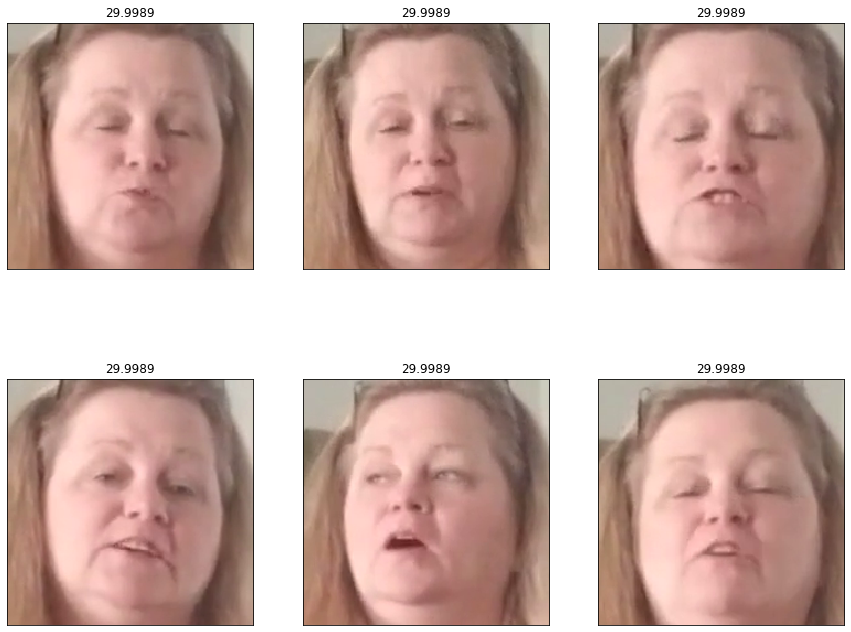

In [82]:
show_faces2(metadata[metadata["label"]=="REAL"][metadata["fps"]==29.9989])

# Find real-fake mapping

In [36]:
samples = np.linspace(0, 299 - 1, 13).round().astype(int)

In [37]:
samples = np.concatenate([samples+i for i in range(8)])
samples = np.array(sorted(samples))

In [38]:
samples

array([  0,   1,   2,   3,   4,   5,   6,   7,  25,  26,  27,  28,  29,
        30,  31,  32,  50,  51,  52,  53,  54,  55,  56,  57,  74,  75,
        76,  77,  78,  79,  80,  81,  99, 100, 101, 102, 103, 104, 105,
       106, 124, 125, 126, 127, 128, 129, 130, 131, 149, 150, 151, 152,
       153, 154, 155, 156, 174, 175, 176, 177, 178, 179, 180, 181, 199,
       200, 201, 202, 203, 204, 205, 206, 224, 225, 226, 227, 228, 229,
       230, 231, 248, 249, 250, 251, 252, 253, 254, 255, 273, 274, 275,
       276, 277, 278, 279, 280, 298, 299, 300, 301, 302, 303, 304, 305])